In [27]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from scipy.special import erf

0.0023690230040521094 1.4701185886767694


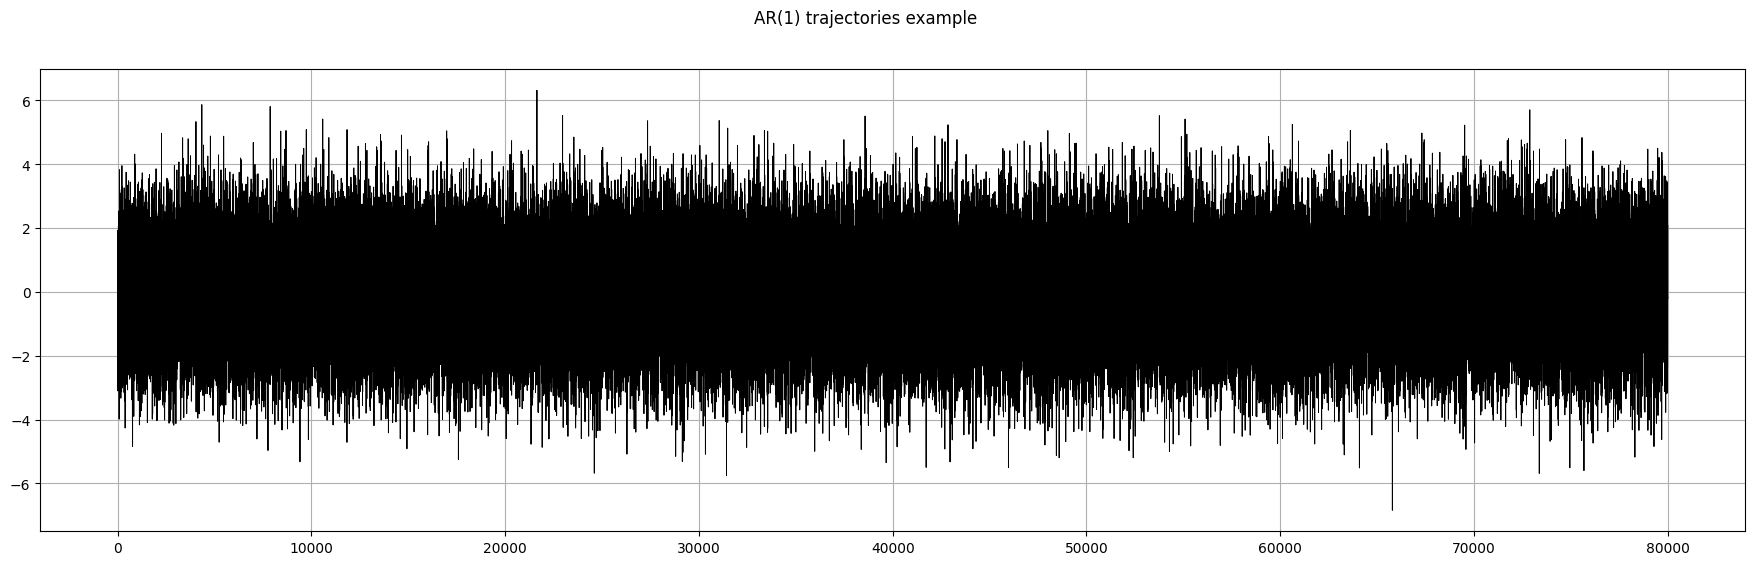

In [3]:
# Смотрим как выглядит случайный процесс
N = 1
theta = -0.2141
plt.figure(figsize=(22, 6)) 
for count_process in range(N):
    y = np.zeros((80000, ))
    for i in range(y.shape[0] - 1):
        plt.subplot(N, 1, count_process + 1)
        y[i + 1] = theta * y[i] + np.random.normal() * 1.4434
    plt.grid(True)
    plt.plot(y, zorder=2, color='k', linewidth=0.7)
print(np.mean(y), np.std(y))
plt.suptitle(f"AR(1) trajectories example")
plt.show()

In [4]:
#Класс, для решения интеграла Фредьгольма II рода
class NystromFredholmSolution: ## Replace by another faster method if enabled
    def __init__(self, upper_bounds, theta, sigma, h):
        self.upper_bounds = upper_bounds # Границы
        self.h = h # Шаг интегрирования
        self.theta = theta # Коэффициент AR(1)
        self.sigma = sigma # STD генерирующего шума
        self.n = len(upper_bounds) # Число отсчетов
        self.trapeziodal_weights = self.initialize_weights()
    
    def initialize_weights(self): # Интегрирование методом трапеций
        trapezoidal_weights = 2 * np.ones((self.n, ))
        trapezoidal_weights[0], trapezoidal_weights[-1] = 1, 1 # Взвешивающие коэффициенты
        return trapezoidal_weights
        
        
    def fredholm_kernel(self, weight, price, upper_bound): # Ядро Фредьгольма II рода
        gain = self.h / (2 * np.sqrt(2 * np.pi) * self.sigma) * weight
        exponential_factor = np.exp(-np.square(price - self.theta * upper_bound) / (2 * self.sigma ** 2))
        return gain * exponential_factor
    
    def get_mean_interval(self): ## Метод Нистрома
        fredholm_kernel = np.zeros((self.n, self.n))
        for i in range(self.n):
            for j in range(self.n):
                fredholm_kernel[i, j] = self.fredholm_kernel(
                    weight=self.trapeziodal_weights[j], 
                    price=self.upper_bounds[j], 
                    upper_bound=self.upper_bounds[i]
                )
                
        fredholm_kernel = np.eye(self.n) - fredholm_kernel
        return np.linalg.solve(fredholm_kernel, np.ones((self.n, ))) # Система линейных уравнений


In [5]:
class MonteCarloAR1:
    # Метод Монте-Карло. Генерируем множество реализаций и ищем среднее время первого прохождения
    def __init__(self, num_trajectories):
        self.num_trajectories = num_trajectories # Число траекторий
        
    def start(self, theta, sigma, expression, init):
        passage_times = [] # Среднее время прохождения для всех инициализаций
        for i in range(self.num_trajectories):
            y_prev = init
            time_counter = 0
            for j in range(1000):
                y_cur = y_prev * theta + np.random.normal(0, sigma)
                time_counter += 1
                if expression(y_cur):
                    passage_times.append(time_counter)
                    break
                y_prev = y_cur
        return np.mean(passage_times)


In [6]:
h = 0.01 # Шаг интегрирования
a, b = 0, 6 # Нижний и верхний пороги (на выходе среднее время прохождения от точки b до нижнего порога a)
sigma = np.sqrt(1.4434 ** 2) # Стандартное отклонение белого шума
theta = -0.2141 # Вес AR(1) процесса
init_prices_sol = np.arange(a, b, h)

fredholm_solver = NystromFredholmSolution(upper_bounds=init_prices_sol, theta=theta, sigma=sigma, h=h)
solution = fredholm_solver.get_mean_interval()

monte_carlo_tester = MonteCarloAR1(num_trajectories=15000)
mean_trading_interval_experiment = []

init_prices_experiment = np.arange(0, b, h)
expression = lambda x: True if x < 0 else False
for init_price in tqdm(init_prices_experiment): # Итерируемся по порогам
    mean_trading_interval_experiment.append(monte_carlo_tester.start(theta, sigma, expression, init_price))

  0%|          | 0/600 [00:00<?, ?it/s]

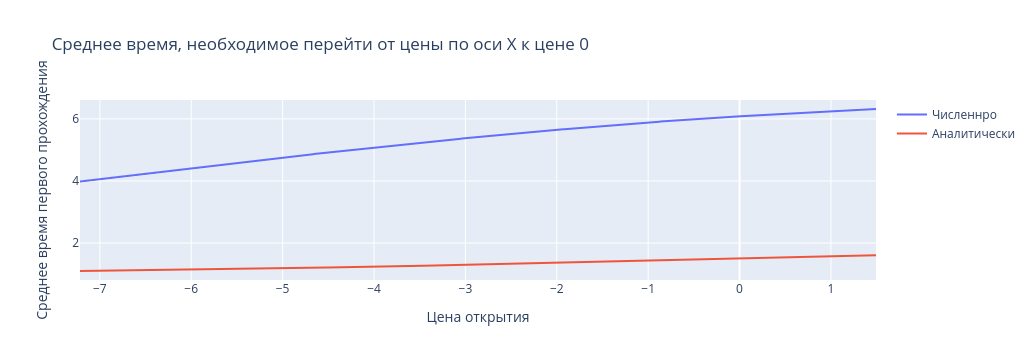

In [31]:
analytical = []
for x in init_prices_sol:
    term1 = erf((b - theta * x) / np.sqrt(2 * sigma))
    term2 = erf((0 - theta * x) / np.sqrt(2 * sigma))
    sol = (term1 + term2 + 2)
    analytical.append(sol)
    
fig = go.Figure(data=[
    go.Scatter(x=init_prices_sol, y=solution, name="Численнро"),
    go.Scatter(x=init_prices_sol, y=analytical, name="Аналитически"),
#     go.Scatter(x=init_prices_experiment, y=mean_trading_interval_experiment, name="Метод Монте-Карло"),
])

fig.update_layout(title=f"Среднее время, необходимое перейти от цены по оси X к цене {a}")
fig.update_yaxes(title="Среднее время первого прохождения")
fig.update_xaxes(title="Цена открытия")
fig.show()

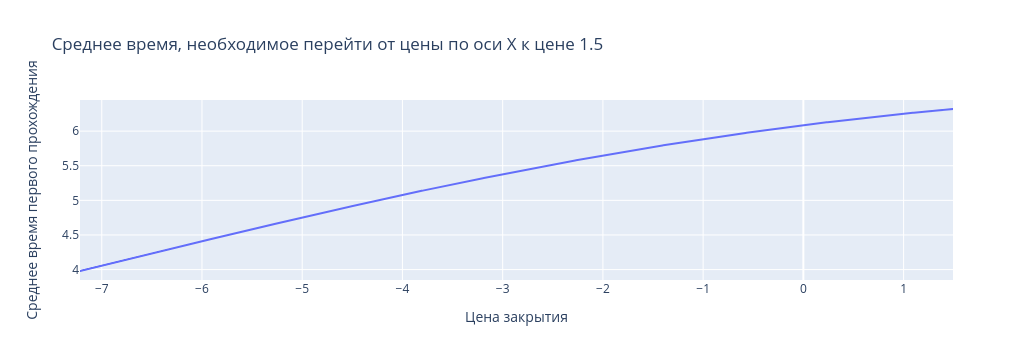

In [8]:
h = 0.01
a, b = 0, 1.5 # Нижний и верхний пороги (на выходе среднее время прохождения от точки b до нижнего порога a)
sigma = np.sqrt(1.4434 ** 2)
theta = -0.2141
init_prices_sol = np.arange(-5 * sigma, b, h)

fredholm_solver = NystromFredholmSolution(upper_bounds=init_prices_sol, theta=theta, sigma=sigma, h=h)
solution = fredholm_solver.get_mean_interval()




fig = go.Figure(data=[
    go.Scatter(x=init_prices_sol, y=solution, name="Решение интеграла"),
])
fig.update_layout(title=f"Среднее время, необходимое перейти от цены по оси X к цене {b}")
fig.update_yaxes(title="Среднее время первого прохождения")
fig.update_xaxes(title="Цена закрытия")
fig.show()

<h1><center> Тестирование метода </center></h1>

In [9]:
h = 0.05# Шаг интегрирования
sigma = np.sqrt(1.4434 ** 2) # Стандартное отклонение генерирующего шума
b = 5 * sigma # Интервал анализа. Вероятность случайного процесса иметь мощность больше чем эта стремится к 0
theta = -0.2141 # Константа AR(1)

init_prices_td = np.arange(0, b, h) # Отрезок дискретных точек интегрирования

fredholm_solver = NystromFredholmSolution( # Инициализация объекта решающего интеграл
    upper_bounds=init_prices_td, 
    theta=theta, 
    sigma=sigma, 
    h=h
)
td = fredholm_solver.get_mean_interval() # TD(U)

In [10]:
print(f"Число x значений: {len(init_prices_td)}")
print(f"Число y значений: {len(td)}")

Число x значений: 145
Число y значений: 145


In [11]:
#I(U)
iu = []
thresholds = []
# Уравнение Фредгольма зависит от конечной точки, но не решается для нулевого МО 
# в экспоненциальной части как это указано в статье
# Так как получается матрицы с переменными параметрами только по диагонали матрицы.(вроде как)
# Из-за этого на выходе имеем константу для любой точки инициализации. Что не совпадает с теорией
for i in tqdm(range(1, len(td))):
    h = 0.05
    sigma = np.sqrt(1.4434 ** 2)
    
    second_a, second_b = -5 * sigma, init_prices_td[i]
    iu_prices = np.arange(second_a, second_b + 0.05, h)
    cur_thresh_solution = NystromFredholmSolution(
        upper_bounds=iu_prices, 
        theta=theta, 
        sigma=sigma, 
        h=h
    ).get_mean_interval()
    zero_index = np.argwhere(np.round(iu_prices, 1) == 0)[0][0]
    iu.append(cur_thresh_solution[zero_index])
    thresholds.append(second_b) 

  0%|          | 0/144 [00:00<?, ?it/s]

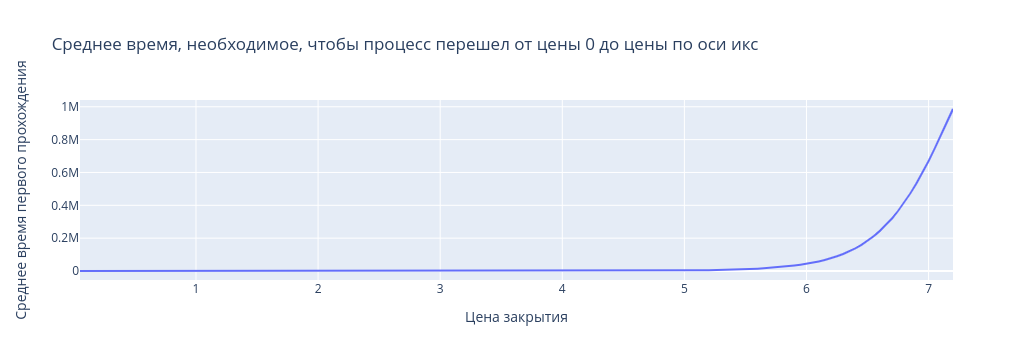

In [12]:
# По методу Монте-Карло проверялся участок до 2.5. Длительность вычислений то и дело, что растет. 
# Но закон в целом похож на эксперимент. Плюс в статье те же значения
fig = go.Figure(data=[
    go.Scatter(x=thresholds, y=iu),
])
fig.update_layout(title=f"Среднее время, необходимое, чтобы процесс перешел от цены 0 до цены по оси икс")
fig.update_yaxes(title="Среднее время первого прохождения")
fig.update_xaxes(title="Цена закрытия")
fig.show()

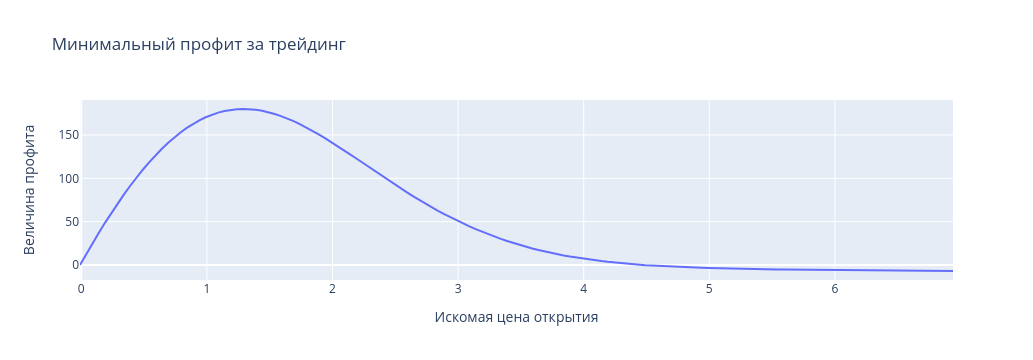

In [20]:
#minimum total profit
T = 1000 # Интервал наблюдения
MTP = (T / (iu[:140] + td[:140]) - 1) * init_prices_td[:140] # Какое то непонятное уравение. не знаю как они его выводили
fig = go.Figure(data=[
    go.Scatter(x=init_prices_td[:144]-0.01, y=MTP),
])
fig.update_layout(title=f"Минимальный профит за трейдинг")
fig.update_yaxes(title="Величина профита")
fig.update_xaxes(title="Искомая цена открытия")
fig.show()

In [21]:
print(f"Средняя прибыль на интервале T: {T} равна {np.max(MTP)}")
print(f"Оптимальный порог: {init_prices_td[np.argmax(MTP)]}")
threshold = init_prices_td[np.argmax(MTP)]

Средняя прибыль на интервале T: 1000 равна 179.9588963781733
Оптимальный порог: 1.3


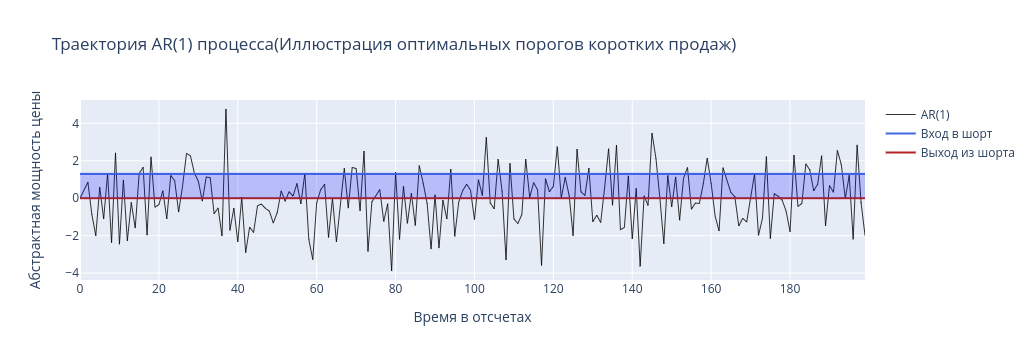

In [22]:
time_interval_to_show = 200 # Область для иллюстрации

ar_trajectory = np.zeros((time_interval_to_show)) # Инициализация

for i in range(time_interval_to_show - 1):
    ar_trajectory[i + 1] = ar_trajectory[i] * theta + np.random.normal(0, sigma)
    
upper = np.ones((time_interval_to_show,)) * threshold
long = -np.ones((time_interval_to_show,)) * threshold
end_position = np.zeros((time_interval_to_show,))

fig = go.Figure(data=[
    go.Scatter(y=ar_trajectory, name="AR(1)", line=dict(color="black", width=0.8)),
    go.Scatter(y=upper, name="Вход в шорт", line=dict(color="royalblue", width=2),),
    go.Scatter(y=end_position, name="Выход из шорта", line=dict(color="firebrick", width=2)),
])

fig.add_hrect(y0=threshold, y1=0, line_width=0, fillcolor="blue", opacity=0.2)
fig.update_layout(title=f"Траектория AR(1) процесса(Иллюстрация оптимальных порогов коротких продаж)")
fig.update_yaxes(title="Абстрактная мощность цены")
fig.update_xaxes(title="Время в отсчетах")

fig.show()

In [23]:
#Оценка профит и лосс кривой 
time_len = 1000
x = np.arange(0, time_len)
ar_trajectory = np.zeros((time_len, ))
start_short = [None] * time_len
end_short = [None] * time_len

start_short_enabled = True
profit_and_loss = []
start_short_price = 0
end_short_price = 0
for i in range(time_len - 1):
    ar_trajectory[i + 1] = ar_trajectory[i] * theta + np.random.normal(0, sigma)
    
    if start_short_enabled and threshold <= ar_trajectory[i + 1]: # Начинаем шорт
        start_short[i + 1] = ar_trajectory[i + 1]
        start_short_enabled = False
        start_short_price = ar_trajectory[i + 1]
        
    if start_short_enabled is False and ar_trajectory[i] > 0 >= ar_trajectory[i + 1]: # Заканчиваем шорт
        end_short[i + 1] = ar_trajectory[i + 1]
        start_short_enabled = True
        end_short_price = ar_trajectory[i + 1]
        profit_and_loss.append(-(end_short_price - start_short_price))
        
upper = np.ones((time_len,)) * threshold
end_position = np.zeros((time_len,)) * threshold  


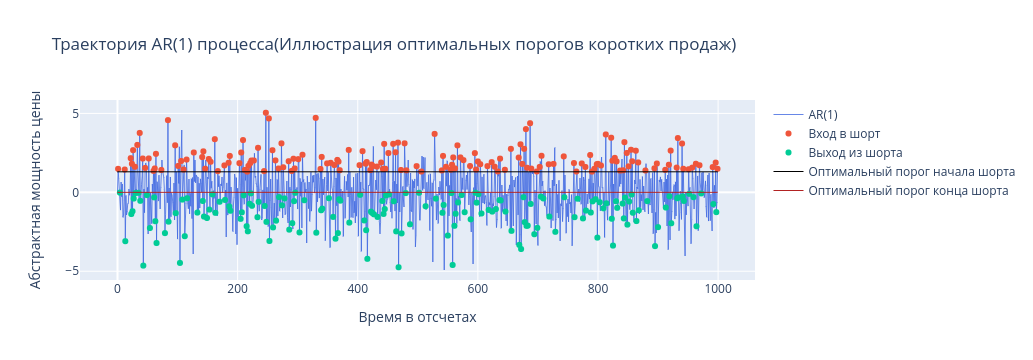

In [24]:
fig = go.Figure(data=[
    go.Scatter(y=ar_trajectory, name="AR(1)", line=dict(color="royalblue", width=0.8)),
    go.Scatter(y=start_short, name="Вход в шорт", mode='markers', line=dict(width=2)),
    go.Scatter(y=end_short, name="Выход из шорта", mode='markers', line=dict(width=2)),
    go.Scatter(y=upper, name="Оптимальный порог начала шорта", line=dict(color="black", width=1)),
    go.Scatter(y=end_position, name="Оптимальный порог конца шорта", line=dict(color="firebrick", width=1)),
])
fig.update_layout(title=f"Траектория AR(1) процесса(Иллюстрация оптимальных порогов коротких продаж)")
fig.update_yaxes(title="Абстрактная мощность цены")
fig.update_xaxes(title="Время в отсчетах")

fig.show()

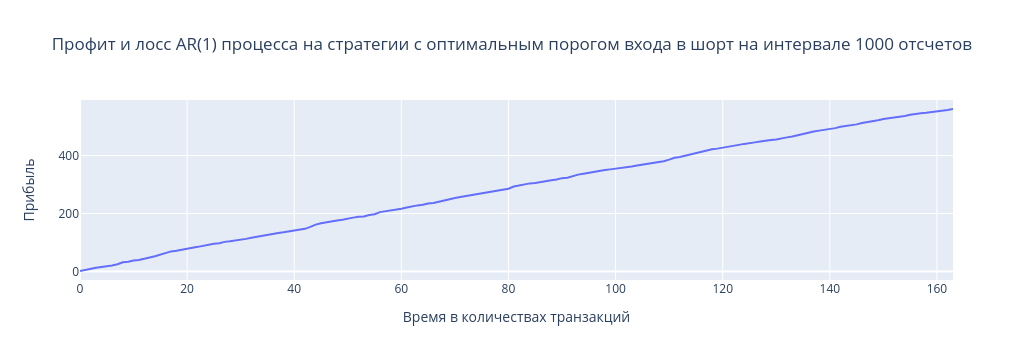

In [26]:
fig = go.Figure(data=go.Scatter(y=np.cumsum(profit_and_loss)))
fig.update_layout(title='Профит и лосс AR(1) процесса на стратегии с оптимальным порогом входа в шорт на интервале 1000 отсчетов')
fig.update_yaxes(title="Прибыль")
fig.update_xaxes(title="Время в количествах транзакций")
fig.show()

<center><h2>Предрасчет порогов для сохранения в базу</h2></center>

In [ ]:
# Среднее время прохождения от цены по оси икс до 0
sigma_arr = np.linspace(5 / 1000, 5, 1000).ravel()
theta_arr = np.linspace(-1, 1, 1000).ravel()
theta_dict = {}
sigma_dict = {}
tensor = np.zeros((len(sigma_arr), len(theta_arr), 600))

print(np.arange(0, 5 * sigma, h).shape)
for i, sigma in enumerate(sigma_arr):
    for j, theta in tqdm(enumerate(theta_arr)):
        integral_range = np.linspace(0, 5 * sigma, 600)
        fredholm_solver = NystromFredholmSolution(
            upper_bounds=integral_range, 
            theta=theta, 
            sigma=sigma, 
            h=integral_range[1] - integral_range[0]
        )
        solution = fredholm_solver.get_mean_interval()
        
        sigma_dict[sigma] = i
        theta_dict[theta] = j
        tensor[i, j, :] = solution.ravel()

(3,)


0it [00:00, ?it/s]

In [ ]:
print(sigma_dict)